In [1]:
import pandas as pd
import datetime
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
minedex = pd.read_csv('../../data/recent_mindex.csv')
minedex.shape

(1222, 13)

In [3]:
# Acess Site.csv for lat and lon.
site_locs = pd.read_excel('../../data/minedex/Sites.xlsx')
site_locs = site_locs[['SiteCode', 'Latitude', 'Longitude']].set_index('SiteCode')
site_locs = site_locs.rename(columns={
    "Latitude": "lat",
    "Longitude": "lon"
})

In [4]:
# minedex = minedex.merge(site_locs, left_on="SiteCode", right_index=True)

In [5]:
full_to_atomic = {'Hydrogen' : 'H', 'Helium' : 'He', 'Lithium' : 'Li', 'Beryllium' : 'Be', 'Boron' : 'B', 'Carbon' : 'C', 'Nitrogen' : 'N', 'Oxygen' : 'O', 'Fluorine' : 'F', 'Neon' : 'Ne', 'Sodium' : 'Na', 'Magnesium' : 'Mg', 'Aluminium' : 'Al', 'Silicon' : 'Si', 'Phosphorus' : 'P', 'Sulfur' : 'S', 'Chlorine' : 'Cl', 'Argon' : 'Ar', 'Potassium' : 'K', 'Calcium' : 'Ca', 'Scandium' : 'Sc', 'Titanium' : 'Ti', 'Vanadium' : 'V', 'Chromium' : 'Cr', 'Manganese' : 'Mn', 'Iron' : 'Fe', 'Cobalt' : 'Co', 'Nickel' : 'Ni', 'Copper' : 'Cu', 'Zinc' : 'Zn', 'Gallium' : 'Ga', 'Germanium' : 'Ge', 'Arsenic' : 'As', 'Selenium' : 'Se', 'Bromine' : 'Br', 'Krypton' : 'Kr', 'Rubidium' : 'Rb', 'Strontium' : 'Sr', 'Yttrium' : 'Y', 'Zirconium' : 'Zr', 'Niobium' : 'Nb', 'Molybdenum' : 'Mo', 'Technetium' : 'Tc', 'Ruthenium' : 'Ru', 'Rhodium' : 'Rh', 'Palladium' : 'Pd', 'Silver' : 'Ag', 'Cadmium' : 'Cd', 'Indium' : 'In', 'Tin' : 'Sn', 'Antimony' : 'Sb', 'Tellurium' : 'Te', 'Iodine' : 'I', 'Xenon' : 'Xe', 'Cesium' : 'Cs', 'Barium' : 'Ba', 'Lanthanum' : 'La', 'Cerium' : 'Ce', 'Praseodymium' : 'Pr', 'Neodymium' : 'Nd', 'Promethium' : 'Pm', 'Samarium' : 'Sm', 'Europium' : 'Eu', 'Gadolinium' : 'Gd', 'Terbium' : 'Tb', 'Dysprosium' : 'Dy', 'Holmium' : 'Ho', 'Erbium' : 'Er', 'Thulium' : 'Tm', 'Ytterbium' : 'Yb', 'Lutetium' : 'Lu', 'Hafnium' : 'Hf', 'Tantalum' : 'Ta', 'Tungsten' : 'W', 'Rhenium' : 'Re', 'Osmium' : 'Os', 'Iridium' : 'Ir', 'Platinum' : 'Pt', 'Gold' : 'Au', 'Mercury' : 'Hg', 'Thallium' : 'Tl', 'Lead' : 'Pb', 'Bismuth' : 'Bi', 'Polonium' : 'Po', 'Astatine' : 'At', 'Radon' : 'Rn', 'Francium' : 'Fr', 'Radium' : 'Ra', 'Actinium' : 'Ac', 'Thorium' : 'Th', 'Protactinium' : 'Pa', 'Uranium' : 'U', 'Neptunium' : 'Np', 'Plutonium' : 'Pu', 'Americium' : 'Am', 'Curium' : 'Cm', 'Berkelium' : 'Bk', 'Californium' : 'Cf', 'Einsteinium' : 'Es', 'Fermium' : 'Fm', 'Mendelevium' : 'Md', 'Nobelium' : 'No', 'Lawrencium' : 'Lr', 'Rutherfordium' : 'Rf', 'Dubnium' : 'Db', 'Seaborgium' : 'Sg', 'Bohrium' : 'Bh', 'Hassium' : 'Hs', 'Meitnerium' : 'Mt', 'Darmstadtium' : 'Ds', 'Roentgenium' : 'Rg', 'Copernicium' : 'Cn', 'Nihonium' : 'Nh', 'Flerovium' : 'Fl', 'Moscovium' : 'Mc', 'Livermorium' : 'Lv', 'Tennessine' : 'Ts', 'Og' : 'Oganesson',}

def convert_to_atomic(col):
    ### NEED TO CATER TO EDGE CASES
    ### e.g Mag Oxide, Alumina etc.
    ###
    full_name = col
    
    if full_name in full_to_atomic.keys():
        atomic = full_to_atomic[full_name]
        return atomic

    else:
        return np.nan
        

minedex['CommodityName'] = minedex['CommodityName'].apply(convert_to_atomic)

In [6]:
### DROPPING WIERD COMMODS FOR NOW.
minedex = minedex[~minedex['CommodityName'].isna()]

In [7]:
# get list of unique mineral combinations
list_combinations = minedex.groupby('SiteCode')['CommodityName'].unique().to_list()

# sort alphabetically
list_combinations = [sorted(commods) for commods in list_combinations]

unique_commods = []
for commods in list_combinations:
    if commods not in unique_commods:
        unique_commods.append(commods)

In [8]:
# WAMEX CLEANING
def replace_neg9999(val):
    if val == -9999: 
        return 0
    else:
        return val
    
    
def abs_halve_neg_val(val):
    if val < 0: 
        return abs(val) / 2
    else: 
        return val

def clean_assays(df):
    df = df.applymap(replace_neg9999)
    df = df.applymap(abs_halve_neg_val)

    # all 9999 -> 0 values are removed
    indexs_0 = df[df.values == 0].index
    df = df.drop(index=indexs_0)
    
    return df

def abundant_ratio(row, abundant_mineral):
    return row / row[abundant_mineral]

def make_pickle_fn(df, model, prefix='../../pickles/'):
    fn = f'{prefix}{type(model).__name__}-'
    for i in df.columns:
        fn = fn + i + '-'

    fn = fn[:-1] + '.pickle'   
    return fn

def filter_by_wamex_minerals(unique_commods, wamex_unique_minerals):
    # filter unique commods by availability in wamex assays
    filtered_unique_commods = []
    for commods in unique_commods:
        filtered_commods = []
        for commod in commods:
            if commod in wamex_unique_minerals:
                filtered_commods.append(commod)
        filtered_unique_commods.append(filtered_commods)
    return filtered_unique_commods

In [9]:
# WAMEX
wamex = pd.read_csv('../../asher/Merged_Ni_lessthan15km.csv',index_col=0)
# wamex.head()

In [10]:
wamex = wamex.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y', 'lat', 'long', 
                     'minedex_coords', 'minedex_site',
                    'distance'])

wamex = wamex.rename(columns={
    "wamex_lat": "lat",
    "wamex_lon": "lon"
})

wamex = wamex.drop_duplicates()

In [11]:
wamex_minerals = wamex.drop(columns=['lat', 'lon'])

wamex.loc[:, wamex_minerals.columns] = clean_assays(wamex.loc[:,wamex_minerals.columns])

# Ratio transform
wamex.loc[:, wamex_minerals.columns] = wamex.loc[:, wamex_minerals.columns].apply(
                                                            abundant_ratio, abundant_mineral='Ni',
                                                            axis=1)

# Available minerals in WAMEX
wamex_unique_minerals = wamex_minerals.columns
filtered_unique_commods = filter_by_wamex_minerals(unique_commods, wamex_unique_minerals)

In [12]:
all_unique_commods = []
for cl in filtered_unique_commods:
    all_unique_commods.extend(cl)

In [13]:
wamex_commods = list(set(all_unique_commods))
wamex_commods

['Co', 'Cu', 'Au', 'Fe', 'Pt', 'Ag', 'S', 'Ni', 'Rh', 'Pd']

In [14]:
minedex = minedex[['SiteCode', 'Date', 'CommodityName', 'ppm']]

# sum up duplicate ppm values 
minedex['ppm'] = minedex.groupby(['SiteCode', 'CommodityName'])['ppm'].transform('sum')

# drop duplicate ppm values.
minedex = minedex.drop_duplicates()

In [15]:
# Filter by WAMEX available commods
minedex = minedex[minedex['CommodityName'].isin(wamex_commods)]

In [16]:
minedex_piv = minedex[['SiteCode', 'CommodityName', 'ppm']]

In [17]:
unique_idxs = minedex_piv[['SiteCode', 'CommodityName']].drop_duplicates().index

# don't know why these are here.
minedex_piv[~minedex_piv.index.isin(unique_idxs)]
minedex_piv = minedex_piv[minedex_piv.index.isin(unique_idxs)]

### Prediction Set

In [18]:
# create a pivot table by SiteCode
minedex_piv = minedex_piv.pivot(index='SiteCode', columns='CommodityName', values='ppm').rename_axis(None)

In [19]:
minedex_piv.columns = minedex_piv.columns.rename(None)

In [20]:
# stupid af workaround to get merge to work.
minedex_piv = minedex_piv.reset_index().merge(site_locs, left_on='index', right_index=True)
minedex_piv

,index,Ag,Au,Co,Cu,Fe,Ni,Pd,Pt,Rh,S,lat,lon
0,S0000192,NaN,NaN,NaN,NaN,NaN,59000.0,NaN,NaN,NaN,NaN,-32.416982,119.689058
1,S0000539,NaN,NaN,NaN,NaN,NaN,20000.0,NaN,NaN,NaN,NaN,-31.011440,121.680000
2,S0001174,NaN,NaN,500.0,53.64,237400.0,15000.0,NaN,NaN,NaN,NaN,-33.633382,120.374303
3,S0001178,NaN,NaN,NaN,NaN,NaN,18500.0,NaN,NaN,NaN,NaN,-30.393502,121.648875
4,S0001188,NaN,NaN,NaN,NaN,NaN,16500.0,NaN,NaN,NaN,NaN,-30.736222,121.802770
...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,S0236620,NaN,NaN,2300.0,NaN,NaN,10900.0,NaN,NaN,NaN,NaN,-32.095677,121.644431
326,S0236621,NaN,NaN,1100.0,NaN,NaN,4500.0,NaN,NaN,NaN,NaN,-32.201621,121.664588
327,S0236838,NaN,NaN,700.0,9000.00,NaN,14000.0,NaN,NaN,NaN,NaN,-31.591497,123.441046
327,S0236838,NaN,NaN,700.0,9000.00,NaN,14000.0,NaN,NaN,NaN,NaN,-31.591497,123.441046


In [21]:
# for each site, make a string of non-null minerals. 
# template: LinearRegression-Ag-Au-Co-Cu-Pd-Pt-lat-lon

minedex_minerals = minedex_piv.drop(columns=['index', 'lat', 'lon'])

def commod_string(row):
    commod_str = "-".join(row.dropna().index.to_list()).replace('-Co', "").replace('Co', "")
    if commod_str.startswith('-'):
        commod_str = commod_str[1:]
    
    row['commod_str'] = commod_str
    return row

minedex_minerals_str = minedex_minerals.apply(commod_string, axis=1)

In [22]:
"Ni-Cu".replace('Co', "")

'Ni-Cu'

In [23]:
minedex_minerals_str['SiteCode'] = minedex_piv['index']
minedex_minerals_str

,Ag,Au,Co,Cu,Fe,Ni,Pd,Pt,Rh,S,commod_str,SiteCode
0,NaN,NaN,NaN,NaN,NaN,59000.0,NaN,NaN,NaN,NaN,Ni,S0000192
1,NaN,NaN,NaN,NaN,NaN,20000.0,NaN,NaN,NaN,NaN,Ni,S0000539
2,NaN,NaN,500.0,53.64,237400.0,15000.0,NaN,NaN,NaN,NaN,Cu-Fe-Ni,S0001174
3,NaN,NaN,NaN,NaN,NaN,18500.0,NaN,NaN,NaN,NaN,Ni,S0001178
4,NaN,NaN,NaN,NaN,NaN,16500.0,NaN,NaN,NaN,NaN,Ni,S0001188
...,...,...,...,...,...,...,...,...,...,...,...,...
325,NaN,NaN,2300.0,NaN,NaN,10900.0,NaN,NaN,NaN,NaN,Ni,S0236620
326,NaN,NaN,1100.0,NaN,NaN,4500.0,NaN,NaN,NaN,NaN,Ni,S0236621
327,NaN,NaN,700.0,9000.00,NaN,14000.0,NaN,NaN,NaN,NaN,Cu-Ni,S0236838
327,NaN,NaN,700.0,9000.00,NaN,14000.0,NaN,NaN,NaN,NaN,Cu-Ni,S0236838


In [24]:
# Add lat and lon
minedex_min_loc = minedex_minerals_str.merge(site_locs, left_on="SiteCode", right_index=True)

In [25]:
minerals_df = minedex_min_loc.drop(columns=['lat', 'lon', 'commod_str', 'SiteCode'])

orig_ni = minerals_df['Ni']

#Ratio transform
# minedex_min_loc.loc[:, minerals_df.columns] = minedex_min_loc.loc[:, minerals_df.columns].apply(
#                                                             abundant_ratio, abundant_mineral='Ni', axis=1)
# apply Log transform
minedex_min_loc.loc[:, minerals_df.columns] = minedex_min_loc.loc[:,minerals_df.columns].apply(np.log, axis=1)

In [26]:
# keep ref of sitecode to index
site_codes_ref = minedex_min_loc['SiteCode']

In [60]:
def load_commod_model(commod_str, model='LinearRegression'):
    path = f'../../pickles/{model}-{commod_str}-lat-lon.pickle'
    with open(path, 'rb') as file:
        m = pickle.load(file)    
    return m, path

In [61]:
# create a list of dataframes by unique commodity groups.
gb = minedex_min_loc.groupby('commod_str')    
list_of_commod_dfs = [gb.get_group(x) for x in gb.groups]

In [64]:
def create_site_pred(commod_group_df):
    '''Gets a dataframe containing a unique commodity group,
    '''
    # drop empty mineral cols
    commod_group_df = commod_group_df.dropna(axis=1)
    # dont know why duplicates
    commod_group_df = commod_group_df.drop_duplicates()
    # create X vars from data.
#     commod_group_df_X = commod_group_df.drop(columns=['commod_str', 'SiteCode', 'Ni'])
    commod_group_df_X = commod_group_df.drop(columns=['commod_str', 'SiteCode'])
    # if site already has a Cobalt value, drop.
    if 'Co' in commod_group_df_X.columns:
        commod_group_df_X = commod_group_df_X.drop(columns=['Co'])
    
    commod_str = commod_group_df['commod_str'].iloc[0]
    paths = []
    try:
        # use first commod string to find relevant model pickle.
        # Linear Regression
        lr, path = load_commod_model(commod_str=commod_str, model='LinearRegression')
        paths.append(path)
        lr_preds = lr.predict(commod_group_df_X)
        commod_group_df['Co_pred_lr'] = lr_preds
        # Random Forest
        rf, path = load_commod_model(commod_str=commod_str, model='RandomForestRegressor')
        paths.append(path)
        rf_preds = rf.predict(commod_group_df_X)
        commod_group_df['Co_pred_rf'] = rf_preds
        
        # make commod_str column
        commod_group_df['commods_used'] = commod_str
            
        site_pred_df = commod_group_df[['SiteCode', 'Co_pred_lr', 'Co_pred_rf', 'commods_used']]

        return site_pred_df, paths
    
    except:
        print(f'Could not find models for {commod_str}')

In [65]:
list_of_site_pred_dfs = []

all_paths = []
for commod_group_df in list_of_commod_dfs:
    site_pred_df, paths = create_site_pred(commod_group_df)
    all_paths.extend(paths)
    list_of_site_pred_dfs.append(site_pred_df)

In [72]:
pd.options.display.max_colwidth = None
def latex_with_lines(df, *args, **kwargs):
    kwargs['column_format'] = '|'.join([''] + ['l'] * df.index.nlevels
                                            + ['r'] * df.shape[1] + [''])
    res = df.to_latex(*args, **kwargs)
    return res.replace('\\\\\n', '\\\\ \\hline\n')

print(latex_with_lines(pd.DataFrame({"Pickle Paths": all_paths})))

\begin{tabular}{|l|r|}
\toprule
{} &                                                          Pickle Paths \\ \hline
\midrule
0  &             ../../pickles/LinearRegression-Ag-Au-Cu-Ni-lat-lon.pickle \\ \hline
1  &        ../../pickles/RandomForestRegressor-Ag-Au-Cu-Ni-lat-lon.pickle \\ \hline
2  &       ../../pickles/LinearRegression-Ag-Au-Cu-Ni-Pd-Pt-lat-lon.pickle \\ \hline
3  &  ../../pickles/RandomForestRegressor-Ag-Au-Cu-Ni-Pd-Pt-lat-lon.pickle \\ \hline
4  &          ../../pickles/LinearRegression-Au-Cu-Ni-Pd-Pt-lat-lon.pickle \\ \hline
5  &     ../../pickles/RandomForestRegressor-Au-Cu-Ni-Pd-Pt-lat-lon.pickle \\ \hline
6  &       ../../pickles/LinearRegression-Au-Cu-Ni-Pd-Pt-Rh-lat-lon.pickle \\ \hline
7  &  ../../pickles/RandomForestRegressor-Au-Cu-Ni-Pd-Pt-Rh-lat-lon.pickle \\ \hline
8  &                ../../pickles/LinearRegression-Cu-Fe-Ni-lat-lon.pickle \\ \hline
9  &           ../../pickles/RandomForestRegressor-Cu-Fe-Ni-lat-lon.pickle \\ \hline
10 &              ../../

In [31]:
all_site_preds_df = pd.concat(list_of_site_pred_dfs, axis=0)

In [32]:
# frik knows why the merge creates duplicates!!!!
all_site_preds_df = all_site_preds_df.merge(minedex[['SiteCode', 'Date']], on='SiteCode').drop_duplicates()

In [33]:
# get original Ni values for inveser transform
# all_site_preds_df = all_site_preds_df.merge(orig_ni, left_index=True, right_index=True).drop_duplicates()

### Invert ratio and log

In [34]:
all_site_preds_df['Co_pred_lr'] = np.exp(all_site_preds_df['Co_pred_lr'])  #* all_site_preds_df['Ni'] 
all_site_preds_df['Co_pred_rf'] = np.exp(all_site_preds_df['Co_pred_rf'])  #* all_site_preds_df['Ni'] 

In [35]:
all_site_preds_df

,SiteCode,Co_pred_lr,Co_pred_rf,commods_used,Date
0,S0230165,235.908886,298.062017,Ag-Au-Cu-Ni,22/06/2020
4,S0018904,697.988768,137.164521,Ag-Au-Cu-Ni-Pd-Pt,09/12/2020
11,S0019102,649.922267,136.569653,Ag-Au-Cu-Ni-Pd-Pt,09/12/2020
18,S0001805,1068.182673,377.826935,Au-Cu-Ni-Pd-Pt,30/06/2015
23,S0004096,170.088795,86.697240,Au-Cu-Ni-Pd-Pt,30/11/2020
...,...,...,...,...,...
556,S0236343,269.927949,259.581803,Ni,19/11/2018
558,S0236620,222.617655,3198.340775,Ni,25/05/2018
560,S0236621,137.904053,489.004517,Ni,25/05/2018
562,S0236992,119.161765,379.350500,Ni,11/12/2018


In [36]:
# all_site_preds_df.merge(true_cobalt)

In [37]:
pd.set_option('display.max_rows', 500)

# add cobalt on
true_cobalt = minedex[minedex['CommodityName'] == 'Co'][['SiteCode', 'ppm']]
all_site_preds_df = all_site_preds_df.merge(true_cobalt, on='SiteCode')
all_site_preds_df = all_site_preds_df.rename(columns={'ppm': 'Co_true'})
# all_site_preds_df

In [38]:
all_site_preds_df = all_site_preds_df[['SiteCode', 'Date', 'commods_used', 'Co_pred_lr', 'Co_pred_rf', 'Co_true']]

In [39]:
all_site_preds_df.to_csv('../../data/preds_lr_rf.csv')

In [40]:
all_site_preds_df.to_csv('./all_site_preds_with_err_no_duplicates.csv')

In [41]:
plot_preds_df = all_site_preds_df[['Co_pred_lr', 'Co_pred_rf', 'Co_true', 'commods_used']].set_index('commods_used')


In [42]:
err_df = pd.read_csv('../../data/model_errors.csv', index_col=0)

def clean_lr_path(row):
    row = row.split('LinearRegression')[1].replace('.pickle','')
    if row.startswith('-'):
        row = row[1:]        
    return row.replace('-lat-lon', '')

err_df['lr_path'] = err_df['lr_path'].apply(clean_lr_path)

In [43]:
all_site_preds_df = all_site_preds_df.merge(err_df.set_index('lr_path'), left_on='commods_used', right_index=True).drop_duplicates(subset='SiteCode')
all_site_preds_df

,SiteCode,Date,commods_used,Co_pred_lr,Co_pred_rf,Co_true,lr_train_mse,lr_test_mse,rf_train_mse,rf_test_mse
0,S0018904,09/12/2020,Ag-Au-Cu-Ni-Pd-Pt,697.988768,137.164521,410.0,0.428619,0.430699,0.033932,0.267269
1,S0019102,09/12/2020,Ag-Au-Cu-Ni-Pd-Pt,649.922267,136.569653,360.0,0.428619,0.430699,0.033932,0.267269
2,S0001174,31/12/2017,Cu-Fe-Ni,314.747747,314.510763,500.0,0.907761,0.931356,0.051680,0.349540
3,S0005631,31/12/2017,Cu-Fe-Ni,277.514417,347.259682,600.0,0.907761,0.931356,0.051680,0.349540
4,S0006586,31/12/2012,Cu-Fe-Ni,192.061664,130.689931,200.0,0.907761,0.931356,0.051680,0.349540
5,S0006685,31/12/2012,Cu-Fe-Ni,363.996006,311.727735,800.0,0.907761,0.931356,0.051680,0.349540
6,S0229459,31/12/2015,Cu-Fe-Ni,172.210609,131.003701,200.0,0.907761,0.931356,0.051680,0.349540
7,S0020966,13/11/2019,Cu-Fe-Ni-S,266.960070,330.146832,500.0,0.922505,1.009840,0.050130,0.406527
8,S0224398,24/02/2015,Cu-Fe-Ni-S,56.328326,94.294070,130.0,0.922505,1.009840,0.050130,0.406527
9,S0001442,02/02/2006,Cu-Ni,671.090123,689.790200,1000.0,0.951613,0.866928,0.055121,0.378050


In [44]:
all_site_preds_df.commods_used.nunique()

10

### Model for : Ag-Au-Cu-Ni-Pd-Pt-lat-lon

In [45]:
import shap

In [49]:
import os

os.listdir('../../pickles/')

['LinearRegression-Ag-Au-Co-Cu-Ni-Pd-Pt-lat-lon.pickle',
 'LinearRegression-Ag-Au-Co-Cu-Pd-Pt-lat-lon.pickle',
 'LinearRegression-Ag-Au-Cu-Co-lat-lon.pickle',
 'LinearRegression-Ag-Au-Cu-Ni-Co-lat-lon.pickle',
 'LinearRegression-Ag-Au-Cu-Ni-lat-lon.pickle',
 'LinearRegression-Ag-Au-Cu-Ni-Pd-Pt-lat-lon.pickle',
 'LinearRegression-Au-Cu-Ni-Pd-Pt-Co-lat-lon.pickle',
 'LinearRegression-Au-Cu-Ni-Pd-Pt-lat-lon.pickle',
 'LinearRegression-Au-Cu-Ni-Pd-Pt-Rh-Co-lat-lon.pickle',
 'LinearRegression-Au-Cu-Ni-Pd-Pt-Rh-lat-lon.pickle',
 'LinearRegression-Au-Cu-Pd-Pt-Co-lat-lon.pickle',
 'LinearRegression-Au-Cu-Pd-Pt-Rh-Co-lat-lon.pickle',
 'LinearRegression-Co-Cu-Fe-lat-lon.pickle',
 'LinearRegression-Co-Cu-Fe-Ni-lat-lon.pickle',
 'LinearRegression-Co-Cu-Fe-Ni-S-lat-lon.pickle',
 'LinearRegression-Co-Cu-Fe-S-lat-lon.pickle',
 'LinearRegression-Co-Cu-lat-lon.pickle',
 'LinearRegression-Co-Cu-Ni-lat-lon.pickle',
 'LinearRegression-Co-Cu-Ni-Pd-lat-lon.pickle',
 'LinearRegression-Co-Cu-Ni-Pd-Pt-lat-lon.

In [52]:
commod_str = 'Ag-Au-Cu-Ni-Pd-Pt-lat-lon'.replace('-lat-lon', '')

lr = load_commod_model(commod_str=commod_str, model='LinearRegression')

In [54]:
make_d


df_inputs = wamex[['Ag', 'Au', 'Cu', 'Ni', 'Pd', 'Pt', 'Co', 'lat', 'lon']]

y = df_inputs['Co']
X = df_inputs.drop(columns=['Co'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

In [55]:
commod_str = commod_group_df['commod_str'].iloc[0]

In [56]:
explainer = shap.LinearExplainer(lr, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.to_numpy() 

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


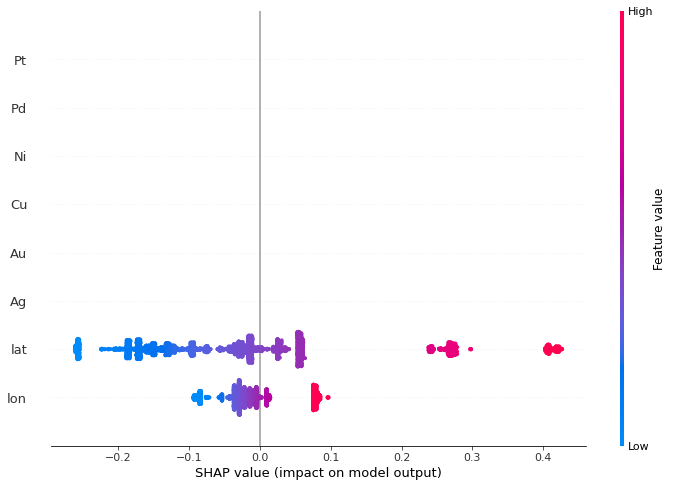

In [57]:
p = shap.summary_plot(shap_values, X_test_array, 
                  feature_names=X_test.columns,
                 plot_size=(12,8), show=False)#.savefig('./shapswarm.png')

In [59]:
os.listdir('../../pickles/')

['LinearRegression-Ag-Au-Co-Cu-Ni-Pd-Pt-lat-lon.pickle',
 'LinearRegression-Ag-Au-Co-Cu-Pd-Pt-lat-lon.pickle',
 'LinearRegression-Ag-Au-Cu-Co-lat-lon.pickle',
 'LinearRegression-Ag-Au-Cu-Ni-Co-lat-lon.pickle',
 'LinearRegression-Ag-Au-Cu-Ni-lat-lon.pickle',
 'LinearRegression-Ag-Au-Cu-Ni-Pd-Pt-lat-lon.pickle',
 'LinearRegression-Au-Cu-Ni-Pd-Pt-Co-lat-lon.pickle',
 'LinearRegression-Au-Cu-Ni-Pd-Pt-lat-lon.pickle',
 'LinearRegression-Au-Cu-Ni-Pd-Pt-Rh-Co-lat-lon.pickle',
 'LinearRegression-Au-Cu-Ni-Pd-Pt-Rh-lat-lon.pickle',
 'LinearRegression-Au-Cu-Pd-Pt-Co-lat-lon.pickle',
 'LinearRegression-Au-Cu-Pd-Pt-Rh-Co-lat-lon.pickle',
 'LinearRegression-Co-Cu-Fe-lat-lon.pickle',
 'LinearRegression-Co-Cu-Fe-Ni-lat-lon.pickle',
 'LinearRegression-Co-Cu-Fe-Ni-S-lat-lon.pickle',
 'LinearRegression-Co-Cu-Fe-S-lat-lon.pickle',
 'LinearRegression-Co-Cu-lat-lon.pickle',
 'LinearRegression-Co-Cu-Ni-lat-lon.pickle',
 'LinearRegression-Co-Cu-Ni-Pd-lat-lon.pickle',
 'LinearRegression-Co-Cu-Ni-Pd-Pt-lat-lon.